In [1]:
%matplotlib inline
from obspy import read, UTCDateTime as UTC
from obspy.signal.cross_correlation import correlation_detector
%matplotlib inline
import obspy
import io
import matplotlib.pyplot as plt
import helpers
import numpy as np
import pandas as pd

from obspy.signal import trigger
from obspy.signal import filter

from datetime import datetime


In [2]:
start = datetime.now()
print(start)
paths = [
'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.01.GDH.2019.138',
'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.01.GDH.2019.139',
'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.01.GDH.2019.140',
'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.01.GDH.2019.141',
'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.01.GDH.2019.142',
#     '/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.02.GDH.2019.138',
# '/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.03.GDH.2019.138',
# '/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.04.GDH.2019.138',
# '/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.05.GDH.2019.138',
# '/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.06.GDH.2019.138'
]
stream_b00 = obspy.read(paths[0])
for p in paths[1:]:
    stream_b00 = stream_b00 + obspy.read(p)

stream_b00.merge()

stream_b00_raw = stream_b00.copy()
stream_b00_raw.normalize()

print(datetime.now()-start)
start = datetime.now()
# this action destroys the raw data
# the wires were crossed on the hydrophone this fixes it
# stream_b00[3].data = stream_b00[3].data.max() - stream_b00[3].data
try:
    stream_b00[3].data = -1 * stream_b00[3].data
except IndexError:
    print('there isnt that many hydrophones in the data set')
    
# this action destroys raw data and only demeaned data is left
stream_b00.detrend('demean')

# this action destroys raw data and only normalized data is left
stream_b00.normalize()

# perform a highpass filter at 40Hz on the data
for t in stream_b00:
    t.data = filter.highpass(t, freq=40, df=1000)
    
# perform a lowpass filter at 5Hz on the data
for t in stream_b00:
    t.data = filter.lowpass(t, freq=5, df=1000)

print(datetime.now()-start)

2021-08-23 17:12:16.737805
0:00:04.847647
there isnt that many hydrophones in the data set
0:02:31.722807


In [3]:
stream_b00

1 Trace(s) in Stream:
7F.B00.01.GDH | 2019-05-18T00:00:02.907000Z - 2019-05-23T00:00:02.116000Z | 1000.0 Hz, 431999210 samples

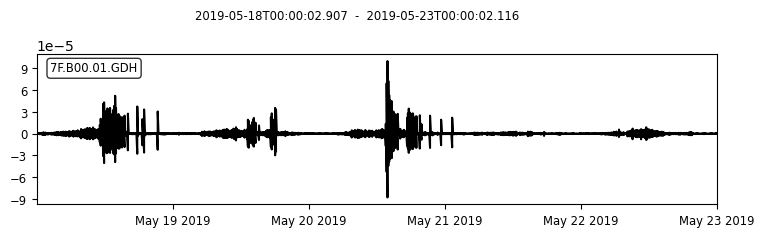

In [4]:
z = stream_b00.plot()

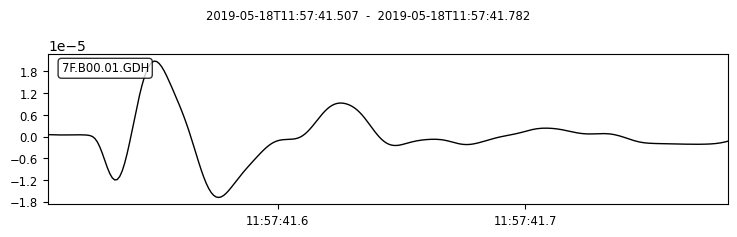

In [5]:
template = stream_b00.copy()
pick = UTC('2019-05-18T11:57:41.532000Z')
template = template.trim(pick-0.025, pick+0.25)
_ = template.plot()
template_tr = template[0].copy()

started at 2021-08-23 17:14:55.964927


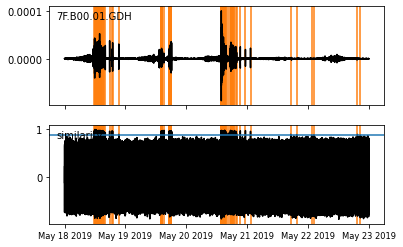

that took 0:01:24.454905
number of detections 604


In [6]:
start = datetime.now()
print('started at', str(start))
height = 0.875
distance = 3
#these should both be streams not traces
detections, sims = correlation_detector(stream=stream_b00
                                        , templates=template
                                        , heights=height
                                        , distance=distance
                                        , plot=stream_b00)

print('that took', str(datetime.now() - start))
print('number of detections', len(detections))

(1.0, 1000.0)

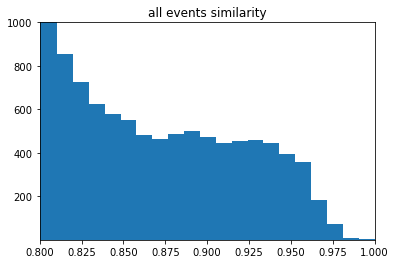

In [7]:
z = plt.hist(sims[0].data, bins=200)
plt.title('all events similarity')
plt.xlim(0.8, 1)
plt.ylim(1e0, 1e3)
# plt.yscale('log')

Text(0.5, 1.0, 'detected events similarity')

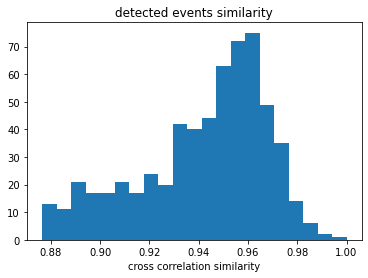

In [8]:
ax = pd.DataFrame(detections).similarity.hist(bins=21, grid=False)
ax.set_xlabel('cross correlation similarity')
ax.set_title('detected events similarity')

In [9]:
detections[0]

{'time': 2019-05-18T11:47:54.445000Z,
 'similarity': 0.96899870833015955,
 'template_id': 0}

In [10]:
detections_idx = np.arange(0, len(detections), 1)

[Text(0, 0.0, 'detection 466'),
 Text(0, 5e-05, 'detection 329'),
 Text(0, 0.0001, 'detection 281'),
 Text(0, 0.00015, 'detection 68'),
 Text(0, 0.0002, 'detection 596'),
 Text(0, 0.00025, 'detection 229'),
 Text(0, 0.0003, 'detection 130'),
 Text(0, 0.00035, 'detection 110'),
 Text(0, 0.0004, 'detection 474'),
 Text(0, 0.00045, 'detection 105')]

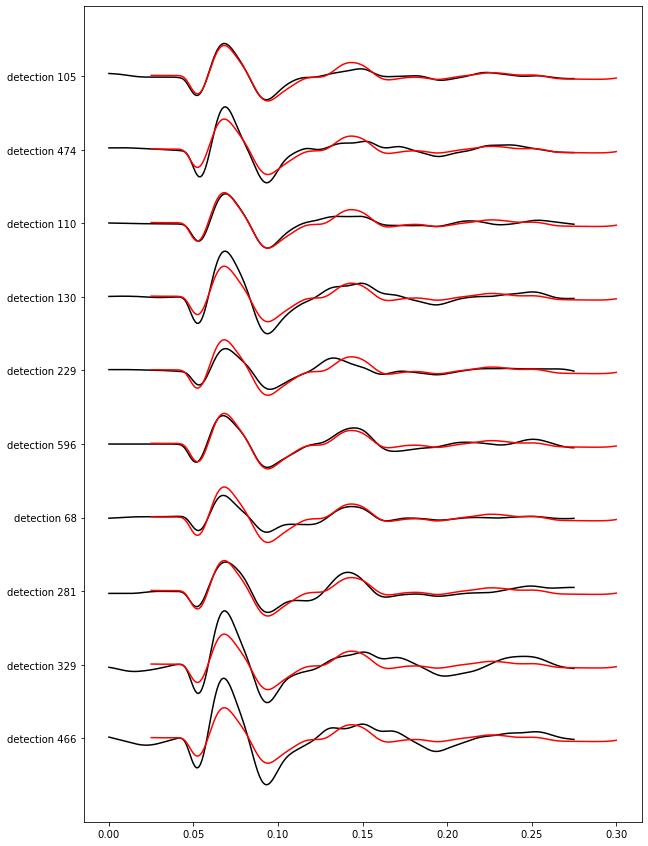

In [11]:


def get_detection_data_time(detection):
    example = stream_b00.copy()
    pick = UTC(detection['time'])
    example.trim(pick-0.025, pick+0.25)
    return example[0].data, example[0].times()





fig, ax = plt.subplots(figsize=(10, 15))
detection_idxs = []

for i in np.arange(0, 10, 1):
    
    ystep = i * 5e-5
    
    i = np.random.choice(detections_idx)
    detection_idxs.append(i)

    y, x = get_detection_data_time(detections[i])
    y = y + ystep

    ax.plot(x, y, label='detection', color='black')

    tempy = template[0].data
    tempx = template[0].times()+0.025 # need to add the amount so it isnt out of phase (see function)
    
    tempy = tempy + ystep
    ax.plot(tempx, tempy, label='template', color='red')
#     break

yticks = np.arange(0, 0.0005, 0.00005)
ax.set_yticks(yticks)
ax.set_yticklabels(['detection {i}'.format(i=i) for i in detection_idxs])

In [12]:
# detection = detections[65]
# example = stream_b00.copy()
# pick = UTC(detection['time'])
# example.trim(pick-0.025, pick+0.25)

# stream_b00_raw.normalize()

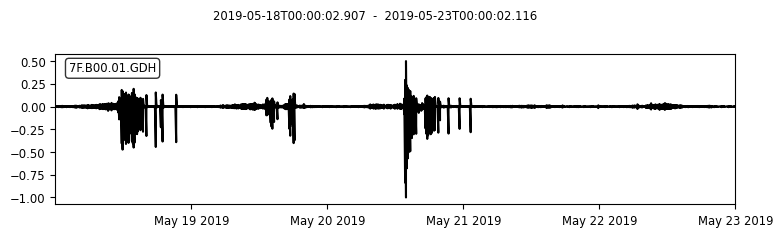

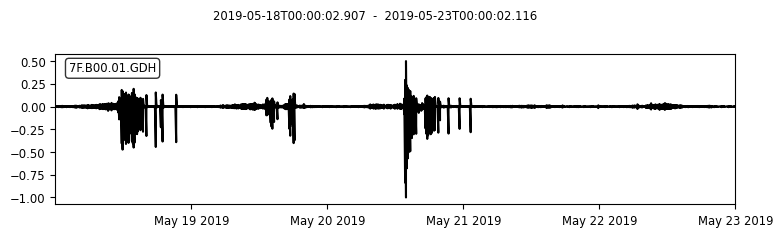

In [13]:
stream_b00_raw.plot()

[Text(0, 0.0, 'detection 151'),
 Text(0, 0.5, 'detection 172'),
 Text(0, 1.0, 'detection 485'),
 Text(0, 1.5, 'detection 236'),
 Text(0, 2.0, 'detection 347'),
 Text(0, 2.5, 'detection 387'),
 Text(0, 3.0, 'detection 529'),
 Text(0, 3.5, 'detection 133'),
 Text(0, 4.0, 'detection 374'),
 Text(0, 4.5, 'detection 490')]

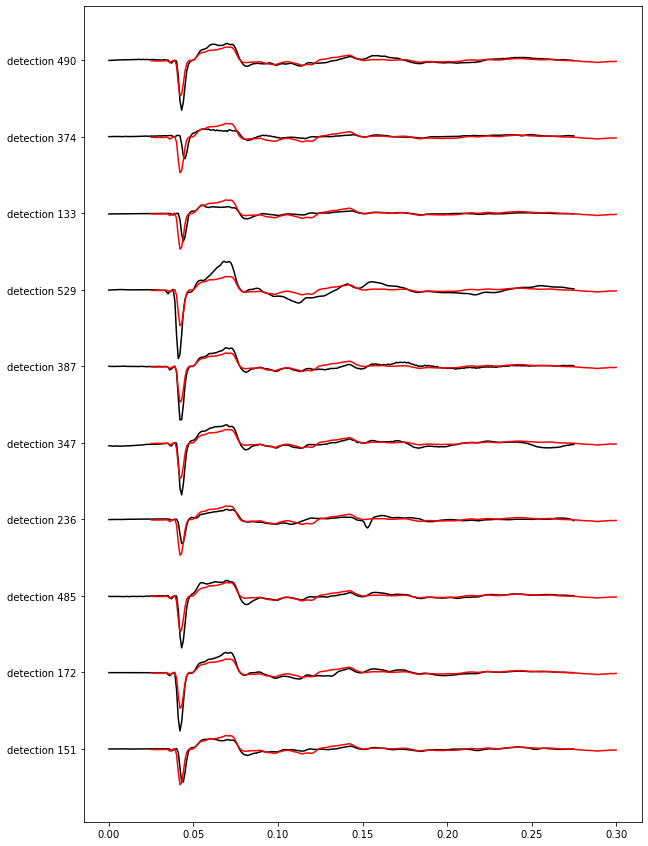

In [28]:
template_raw = stream_b00_raw.copy()
pick = UTC('2019-05-18T11:57:41.532000Z')
template_raw = template_raw.trim(pick-0.025, pick+0.25)
# _ = template_raw.plot()
# template_tr = template[0].copy()


def get_raw_detection_data_time(detection):
    example = stream_b00_raw.copy()
    pick = UTC(detection['time'])
    example.trim(pick-0.025, pick+0.25)
    return example[0].data, example[0].times()

fig, ax = plt.subplots(figsize=(10, 15))


# y = example[0].data
# x = example[0].times()

detection_idxs = []

for i in np.arange(0, 10, 1):
    
    ystep = i/2. #* 5e-5
    
    i = np.random.choice(detections_idx)
    detection_idxs.append(i)

    y, x = get_raw_detection_data_time(detections[i])
    y = y + ystep

    ax.plot(x, y, label='detection', color='black')

    tempy = template_raw[0].data
    tempx = template_raw[0].times()+0.025 # need to add the amount so it isnt out of phase (see function)
    
    tempy = tempy + ystep
    ax.plot(tempx, tempy, label='template', color='red')
#     break

yticks = np.arange(0, 5, 0.5)
ax.set_yticks(yticks)
ax.set_yticklabels(['detection {i}'.format(i=i) for i in detection_idxs])